In [384]:

from statistics import mean, mode
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
#from sklearn.metrics import roc_curve as roc

In [385]:
import numpy as np

In [386]:
# https://towardsdatascience.com/lstms-in-pytorch-528b0440244
# https://github.com/IHCA-Coding-to-Prevent-Coding/ML-SampleNeuralNet/blob/main/sampleneuralnet.py
# data from https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city#

In [387]:
data = pd.read_csv('Tetuan City power consumption.csv')
data.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

In [388]:
#first week of data is training, second week is testing
splitPoint = 144*7

trainTruth = data.iloc[:splitPoint, [6]]
training = data.iloc[:splitPoint, [1, 2, 3, 4, 5]]

testTruth = data.iloc[splitPoint:splitPoint*2, [6]]
testing = data.iloc[splitPoint:splitPoint*2, [1, 2, 3, 4, 5]]

trainTruth = torch.tensor(trainTruth.values)
training = torch.tensor(training.values)

testTruth = torch.tensor(testTruth.values)
testing = torch.tensor(testing.values)

training = training.float()
testing = testing.float()
trainTruth = trainTruth.float()
testTruth = testTruth.float()

In [389]:
# binary values, if power usage is above average
# getting if power usage is above average
average = mean(x.item() for x in testTruth)

binaryTestTruth = torch.tensor([float(x>average) for x in testTruth])

binaryTrainTruth = torch.tensor([float(x>average) for x in trainTruth])

In [390]:
# alternate data splitting that isn't week by week
# TODO assert failing, or maybe they aren't supposed to be same length
'''
xValues = data.iloc[:, [1, 2, 3, 4, 5]]
yValues = data.iloc[:, [6]]

training, testing, testTruth, trainTruth = train_test_split(xValues, yValues)
# assert len(training)==len(trainTruth)
'''

'\nxValues = data.iloc[:, [1, 2, 3, 4, 5]]\nyValues = data.iloc[:, [6]]\n\ntraining, testing, testTruth, trainTruth = train_test_split(xValues, yValues)\n# assert len(training)==len(trainTruth)\n'

c:\Users\natha\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1008])) that is different to the input size (torch.Size([1008, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


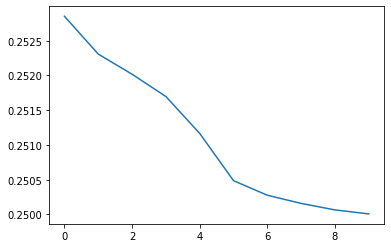

In [391]:
#testing = torch.randn(batchSize, seqLength, inputSize)

inputSize=5 # variables input
hiddenSizeOne=32 # nodes of hidden layer
hiddenSizeTwo=32 # nodes of hidden layer
outSize=1 # power consumptoion in zone 1
batchSize= 144*7 # how many data points are in batch
lr = 0.05
seqLength=144 # num of time values per input
epochSize = 10

class extractTensor(nn.Module):
    def forward(self, x):
        tensor, hs = x
        return tensor.reshape(-1, hiddenSizeOne) 

model = nn.Sequential(
    nn.LSTM(inputSize, hiddenSizeOne),
    extractTensor(),
    #nn.Sigmoid(),
    nn.Linear(hiddenSizeOne, hiddenSizeTwo),
    #nn.Sigmoid(),
    nn.Linear(hiddenSizeTwo, outSize),
    nn.Sigmoid() # increases AUROC, decreases accuracy
    #nn.Linear(linearSize, outSize)
)

def lossFunc(data=training, comparison=trainTruth, model=model):
    prediction = model(data)

    MSEloss = torch.nn.MSELoss()
    output = MSEloss(prediction, comparison)
    
    return output, prediction

optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# model training starts here
lossList = []
for i in range(epochSize):
    loss, output = lossFunc(comparison = binaryTrainTruth)
    lossList.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(lossList)
training_loss = loss.item();

In [392]:
with torch.no_grad():
    testing_loss, prediction = lossFunc(testing, binaryTestTruth);
    testing_loss = testing_loss.item()
   
    print(f"training loss:    {training_loss}");
    print(f"testing loss:     {testing_loss}");
    print(f"testing-training: {testing_loss-training_loss}");
    print(f"testing/training: {training_loss/testing_loss}");
    print(f"% error           {(testing_loss-training_loss)/testing_loss}");

training loss:    0.25000685453414917
testing loss:     0.2525031864643097
testing-training: 0.0024963319301605225
testing/training: 0.9901136616724899
% error           0.009886338327510054


In [393]:
common = mode([float(x) for x in output])

count=0
for x in output:
    if x == common:
        count+=1

print(f'predicting same thing {count/len(prediction)*100}%')

predicting same thing 0.1984126984126984%


In [394]:
# rounding percentage chances to 1 or 0 floats
binaryPred = []
for pred in prediction:
    if pred.item() >= 0.5:
        binaryPred.append(1.0)
    else:
        binaryPred.append(0)

In [395]:
# https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb

# continuous auroc calculator from the internet
def regression_roc_auc_score(y_true, y_pred, num_rounds = 10000):
  """
  Computes Regression-ROC-AUC-score.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  y_pred: array-like of shape (n_samples,). Target scores.
  num_rounds: int or string. If integer, number of random pairs of observations. 
              If string, 'exact', all possible pairs of observations will be evaluated.
  
  Returns:
  -------
  rroc: float. Regression-ROC-AUC-score.
  """

    
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  num_pairs = 0
  num_same_sign = 0
  
  for i, j in _yield_pairs(y_true, num_rounds):
    diff_true = y_true[i] - y_true[j]
    diff_score = y_pred[i] - y_pred[j]
    if diff_true * diff_score > 0:
      num_same_sign += 1
    elif diff_score == 0:
      num_same_sign += .5
    num_pairs += 1
      
  return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
  """
  Returns pairs of valid indices. Indices must belong to observations having different values.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  num_rounds: int or string. If integer, number of random pairs of observations to return. 
              If string, 'exact', all possible pairs of observations will be returned.
  
  Yields:
  -------
  i, j: tuple of int of shape (2,). Indices referred to a pair of samples.
  
  """
  
  if num_rounds == 'exact':
    for i in range(len(y_true)):
      for j in np.where((y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
        yield i, j     
  else:
    for r in range(num_rounds):
      i = np.random.choice(range(len(y_true)))
      j = np.random.choice(np.where(y_true != y_true[i])[0])
      yield i, j

In [396]:
'''
roc_auc_score is defined as the area under the ROC curve, which is the curve having False Positive Rate on the x-axis 
and True Positive Rate on the y-axis at all classification thresholds. 
But it’s impossible to calculate FPR and TPR for regression methods, so we cannot take this road.

Luckily for us, there is an alternative definition. In fact, according to Wikipedia, 
roc_auc_score coincides with “the probability that a classifier will rank a randomly 
chosen positive instance higher than a randomly chosen negative one”.
'''
# is this what we want??

print(f"AUROC value: {regression_roc_auc_score(binaryTestTruth, binaryPred)}")

AUROC value: 0.61865


In [397]:
# accuracy for binary prediction

correct=0
for i in range(len(binaryPred)):
    if binaryPred[i] == binaryTestTruth[i]:
        correct+=1
print(f'accuracy: {(correct/ len(prediction))*100}')


accuracy: 58.82936507936508


In [ ]:
# TODO better data collection, not just week by week
# TODO need cross validation, individual runs vary by +-10% accuracy